<a href="https://colab.research.google.com/github/phamhoainguyen/colab/blob/main/Lab_5_Food_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phân loại đa lớp
Sử dụng kiến trúc TinyVGG để phân loại 10 lớp ảnh khác nhau.

Quy trình thực hiện:
1. Làm quen với dữ liệu (visualize, visualize, visualize...)
2. Tiền xử lý dữ liệu (chuẩn bị cho mô hình)
3. Tạo mô hình (bắt đầu với baseline)
4. Khớp mô hình
5. Đánh giá mô hình
6. Điều chỉnh các tham số khác nhau và cải thiện mô hình (thử vượt qua baseline)
7. Lặp lại cho tới khi hài lòng

## 1) Download and explore data

In [ ]:
import os
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import zipfile
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

#giải nén file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-08 03:56:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   135MB/s    in 3.8s    

2022-05-08 03:56:41 (132 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

Thiết lập đường dẫn cho train/test directory

In [ ]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

Lấy tên lớp từ subdirectory

In [ ]:
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)


['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [ ]:

def view_random_image(target_dir, target_class):
    '''@param target_dir like 'dataset/train/'
    \n@param target_class like 'pizza' '''

    # Specify the folder to get image
    target_folder = target_dir + target_class

    # Pick 1 random image name
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read the image file and show 
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    # Print shape of the image
    print(f"Image shape: {img.shape}")

    return img

In [ ]:
def view_image(target_dir, file_name):
    '''@param target_dir like 'dataset/train/'
    \n@param file_name like 'img001.png' '''

    # Specify the image file
    target_file = target_dir + file_name

    img = mpimg.imread(target_file)
    plt.imshow(img)
    plt.title(file_name)
    plt.axis("off")

    # Print the shape of the image
    print(f"Image shape: {img.shape}")

    return img




Image shape: (512, 382, 3)


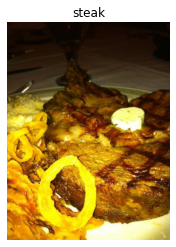

In [ ]:
# Show a random image from train set
tf.random.set_seed(42)
img = view_random_image(target_dir=train_dir,
                            target_class=random.choice(class_names))

## 2) Preprocessing

In [ ]:
# Rescale dữ liệu và tạo các data generator instance

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load dữ liệu từ các directory và biến nó thành các batch
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # thay thành categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


Take a look at classes dictionary


In [ ]:
class_dictionary = train_data.class_indices
class_dictionary

{'chicken_curry': 0,
 'chicken_wings': 1,
 'fried_rice': 2,
 'grilled_salmon': 3,
 'hamburger': 4,
 'ice_cream': 5,
 'pizza': 6,
 'ramen': 7,
 'steak': 8,
 'sushi': 9}

## 3) Create a baseline model (TinyVGG)
Cụ thể:
* Thay đổi layer đầu ra thành 10 nơ-ron đầu ra (số lớp tương tự với số lớp chúng ta có).
* Thay đổi layer đầu ra để sử dụng kích hoạt `'softmax'` thay vì kích hoạt `'sigmoid'`.
* Thay đổi hàm mất mát thành `'categorical_crossentropy'` thay vì `'binary_crossentropy'`.

The architech of baseline TinyVGG:

Conv2D -> Conv2D -> MaxPool2D -> Conv2D -> Conv2D -> MaxPool2D -> Flatten -> Dense(softmax)

In [ ]:
# TinyVGG model

model_1 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10,3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax")
])

In [ ]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

## 4) Fitting the model

In [ ]:
history_1 = model_1.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 57s 240ms/step - loss: 2.3123 - accuracy: 0.0589 - val_loss: 2.3024 - val_accuracy: 0.1012
Epoch 2/5
235/235 [==============================] - 56s 239ms/step - loss: 2.3057 - accuracy: 0.0823 - val_loss: 2.3009 - val_accuracy: 0.0980
Epoch 3/5
235/235 [==============================] - 56s 239ms/step - loss: 2.3005 - accuracy: 0.1135 - val_loss: 2.2971 - val_accuracy: 0.1272
Epoch 4/5
235/235 [==============================] - 56s 237ms/step - loss: 2.2370 - accuracy: 0.1896 - val_loss: 2.3220 - val_accuracy: 0.1424
Epoch 5/5
235/235 [==============================] - 55s 235ms/step - loss: 2.0086 - accuracy: 0.2935 - val_loss: 2.3354 - val_accuracy: 0.1588


In [ ]:
# Vẽ biểu đồ dữ liệu kiểm định và huấn luyện riêng biệt
def plot_loss_curves(history):
  """
  Trả về loss curve riêng biệt cho các phép đo huấn luyện và kiểm định.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Vẽ loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Vẽ accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
# model_1.evaluate(test_data)

In [ ]:
plot_loss_curves(history_1)

We can see the model is learning, we try to increase epoch


In [ ]:
# TinyVGG model

# Clone mô hình (sử dụng kiến trúc tương tự)
model_2 = tf.keras.models.clone_model(model_1)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
# history_2 = model_2.fit(train_data,
#                       epochs=7,
#                       steps_per_epoch=len(train_data),
#                       validation_data=test_data,
#                       validation_steps=len(test_data))

In [ ]:
# plot_loss_curves(history_2)

In [ ]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
# Tạo hàm import hình ảnh và resize nó để sử dụng với mô hình
def load_and_prep_image(filename, img_shape=224):
  """
  Đọc ảnh từ tên file, biến nó thành tensor
  và reshape nó thành (img_shape, img_shape, colour_channel).
  """
  # Đọc trong target file (hình ảnh)
  img = tf.io.read_file(filename)

  # Giải mã file đã đọc thành tensor & đảm bảo 3 kênh màu
  # (mô hình được huấn luyện trên ảnh có 3 kênh màu và đôi lúc ảnh có 4 kênh màu) 
  img = tf.image.decode_image(img, channels=3)

  # Resize ảnh (về cùng size mà mô hình được huấn luyện)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale ảnh (nhận tất cả các giá trị trong khoảng 0-1)
  img = img/255.
  return img

In [ ]:
# Điều chỉnh hàm để làm việc với nhiều lớp
def pred_and_plot(model, filename, class_names):
  """
  Import ảnh trong filename, đưa ra dự đoán về nó với
  mô hình đã huấn luyện và vẽ ảnh với lớp đã dự đoán làm tiêu đề.
  """
  # Import ảnh mục tiêu và tiền xử lý nó
  img = load_and_prep_image(filename)

  # Đưa ra dự đoán
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Lấy tên lớp đã dự đoán
  if len(pred[0]) > 1: # kiểm tra cho nhiều lớp
    pred_class = class_names[pred.argmax()] # nếu có nhiều hơn một đầu ra, lấy giá trị lớn nhất
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # nếu chỉ có một đầu ra, làm tròn

  # Vẽ ảnh và lớp đã dự đoán
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}, the confidence is {np.round(np.max(pred) * 100, 2)}")
  plt.axis(False);

In [ ]:
np.round(0.984343432, 5)

0.98434

--2022-05-08 03:57:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.06s   

2022-05-08 03:57:03 (30.8 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



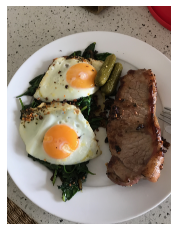

In [ ]:
# Xem hình ảnh ví dụ
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

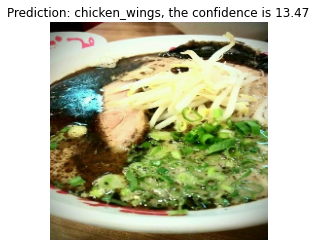

In [ ]:
# Kiểm tra mô hình trên ảnh tùy chỉnh
pred_and_plot(model_2, "10_food_classes_all_data/train/ramen/1002305.jpg", class_names)

In [ ]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

## 5) Improve the model


### 5.1) Data augmentation

In [ ]:
# Tạo ImageDataGenerator training instance với data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # xoay hình một chút trong khoảng 0-20 độ (lưu ý: đây là int, không phải float)
                                             shear_range=0.2, # cắt ảnh
                                             zoom_range=0.2, # phóng to ảnh
                                             width_shift_range=0.2, # dịch chuyển ảnh theo chiều rộng
                                             height_shift_range=0.2, # dịch chuyển ảnh theo chiều cao
                                             horizontal_flip=True) # lật ảnh trên trục hoành

# Tạo ImageDataGenerator training instance mà không có data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Tạo ImageDataGenerator test instance mà không có data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Import dữ liệu và tăng cường nó từ training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='categorical',
                                                                   shuffle=False) # Không xáo trộn cho mục đích mô phỏng

train_data_augmented_shuffed = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='categorical',
                                                                   shuffle=True)


# Tạo các non-augmented data batch
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False) # Không xáo trộn cho mục đích mô phỏng


print("Non-augmented training images:")
train_data_shuffed = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=True) 
print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='categorical')

Augmented training images:
Found 7500 images belonging to 10 classes.
Found 7500 images belonging to 10 classes.
Non-augmented training images:
Found 7500 images belonging to 10 classes.
Unchanged test images:
Found 2500 images belonging to 10 classes.


In [ ]:
# Lấy mẫu data batch
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Lưu ý: các nhãn không được tăng cường, chúng vẫn giữ nguyên

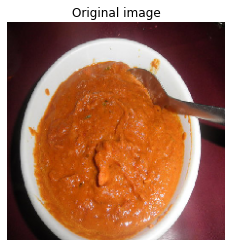

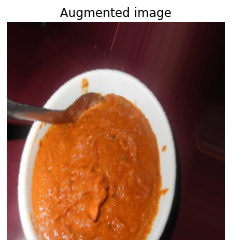

In [ ]:
# Hiển thị hình ảnh ban đầu và hình ảnh đã tăng cường
random_number = random.randint(0, 32) # chúng ta đang tạo batch có size 32 để lấy instance ngẫu nhiên
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

Train the model_2 with train_data_augmented_shuffed


In [ ]:
# TinyVGG model

# Clone mô hình (sử dụng kiến trúc tương tự)
model_3 = tf.keras.models.clone_model(model_1)

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
history_3 = model_3.fit(train_data_augmented_shuffed,
                      epochs=7,
                      steps_per_epoch=len(train_data_augmented_shuffed),
                      validation_data=test_data,
                      validation_steps=len(test_data))

Epoch 1/7
235/235 [==============================] - 129s 546ms/step - loss: 2.2109 - accuracy: 0.1765 - val_loss: 2.0646 - val_accuracy: 0.2840
Epoch 2/7
235/235 [==============================] - 128s 543ms/step - loss: 2.0696 - accuracy: 0.2641 - val_loss: 1.9629 - val_accuracy: 0.2972
Epoch 3/7
235/235 [==============================] - 126s 535ms/step - loss: 2.0130 - accuracy: 0.2885 - val_loss: 1.8412 - val_accuracy: 0.3656
Epoch 4/7
235/235 [==============================] - 135s 574ms/step - loss: 1.9632 - accuracy: 0.3140 - val_loss: 1.8475 - val_accuracy: 0.3516
Epoch 5/7
235/235 [==============================] - 126s 536ms/step - loss: 1.9109 - accuracy: 0.3399 - val_loss: 1.7326 - val_accuracy: 0.4124
Epoch 6/7
235/235 [==============================] - 125s 530ms/step - loss: 1.9040 - accuracy: 0.3433 - val_loss: 1.7662 - val_accuracy: 0.4064
Epoch 7/7
235/235 [==============================] - 124s 528ms/step - loss: 1.8860 - accuracy: 0.3536 - val_loss: 1.7930 - val_ac

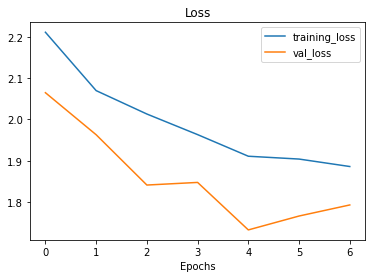

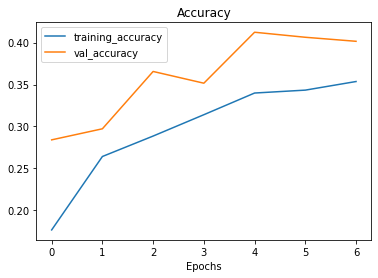

In [ ]:
plot_loss_curves(history_3)

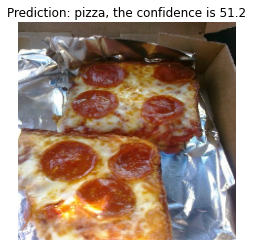

In [ ]:
# Kiểm tra mô hình trên ảnh tùy chỉnh
pred_and_plot(model_3, "10_food_classes_all_data/test/pizza/11297.jpg", class_names)